<a href="https://colab.research.google.com/github/frederic-jurie/frederic-jurie.github.io/blob/master/mnist_autoencoders.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pytorch implementations of MNIST autoencoders



In [0]:
import torchvision
import math
import torch
import torch.nn as nn
import torch.nn.functional as F 
import torch.optim as optim
import torch.autograd as autograd
import numpy as np
from torch.utils.data import DataLoader
print(torch.cuda.is_available())

True


In [0]:
from google.colab import drive
drive.mount('/content/gdrive')
!ls '/content/gdrive/My Drive/tmp'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive
autoencoder_minist_conv2.pt  autoencoder_minist_conv5.pt  MNIST
autoencoder_minist_conv3.pt  autoencoder_minist_conv6.pt
autoencoder_minist_conv4.pt  autoencoder_minist_conv.pt


### Let's load the dataset

In [0]:
# trans = torchvision.transforms.ToTensor() # use this if no transform required
trans = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5,), (0.5, ))
])
test_set = torchvision.datasets.MNIST(root='/content/gdrive/My Drive/tmp', train=False, download=True, transform=trans)
train_set = torchvision.datasets.MNIST(root='/content/gdrive/My Drive/tmp', train=True, download=True, transform=trans)
print('taille trainset:',len(train_set),'taille testset:',len(test_set))

taille trainset: 60000 taille testset: 10000


# autoencoder models

In [0]:
class AE_MNIST(nn.Module):
    def __init__(self,h=15):
        super(AE_MNIST, self).__init__()
        self.l1 = nn.Linear(28*28, h)
        self.l2 = nn.Linear(h, 28*28)

    def forward(self, x):
#        z =  torch.sign(self.l1(x.view(x.shape[0], -1)))
        z =  (self.l1(x.view(x.shape[0], -1)))
        return self.l2(z).view(x.shape[0], -1, 28, 28),z

class EncoderMNIST(nn.Module):
    def __init__(self,h=15):
        super(EncoderMNIST, self).__init__()
        self.conv = nn.Sequential(
                nn.Conv2d(1, 8, 5, padding=2),
                nn.BatchNorm2d(8),
                nn.LeakyReLU(),
                nn.AvgPool2d(2),
                nn.Conv2d(8, 16, 5, padding=2),
                nn.BatchNorm2d(16),
                nn.LeakyReLU(),
                nn.AvgPool2d(2),
            )
        self.ff = nn.Sequential(
                nn.Linear(7*7*16, 64),
                nn.BatchNorm1d(64),
                nn.LeakyReLU(),
                nn.Linear(64, h),
                nn.BatchNorm1d(h)
            )
    def forward(self, x):
        y = self.conv(x)
        y = y.view(y.shape[0], -1)
        y = self.ff(y)
        return y

class DecoderMNIST(nn.Module):
    def __init__(self,h=15):
        super(DecoderMNIST, self).__init__()
        self.ff = nn.Sequential(
                nn.Linear(h, 64),
                nn.LeakyReLU(),
                nn.Linear(64, 7*7*16),
            )
        self.deconv = nn.Sequential(
                nn.Upsample(scale_factor=2),
                nn.ConvTranspose2d(16, 8, 5, padding=2),
                nn.BatchNorm2d(8),
                nn.LeakyReLU(),
                nn.Upsample(scale_factor=2),
                nn.ConvTranspose2d(8, 1, 5, padding=2),
                nn.BatchNorm2d(1),
                nn.Tanh(),
            )
    def forward(self, x):
        y = self.ff(x)
        y = y.view(y.shape[0], -1, 7, 7)
        y = self.deconv(y)
        return y

class AUTO_CONV(nn.Module):
    def __init__(self,h=15):
        super(AUTO_CONV, self).__init__()
        self.enc = EncoderMNIST(h)
        self.dec = DecoderMNIST(h)
        
    def forward(self, x, sampling=False):
        z = self.enc(x)
        y = self.dec(z)
        return y, z


### Let's learn the model

In [0]:
# global variables
h=2 # dimension of the latent space
my_file = Path('/content/gdrive/My Drive/tmp/autoencoder_minist_conv6.pt') # where to store the model
lr = 0.1

In [0]:
from pathlib import Path

net = AUTO_CONV(h=2)
net = AUTO_CONV(h=2)

if torch.cuda.is_available():
  net.cuda()

if my_file.is_file():
    state = torch.load(my_file)
    net.load_state_dict(state['net'])

opt = optim.Adam(net.parameters(),  lr=lr)

epoch = 0
criterion = nn.MSELoss()
while True:
    rloss = 0
    for index, (X, _) in enumerate(loader):
        x, z = net(X) if not torch.cuda.is_available else net(X.cuda())
        loss =  criterion(x, X) if not torch.cuda.is_available else criterion(x.cuda(), X.cuda())
        opt.zero_grad()
        loss.backward()
        opt.step()
        rloss += loss.item()
    torch.save({'opt':opt.state_dict(), 'net':net.state_dict()}, my_file)
    print(rloss/(index + 1))

0.1582908894080343
0.15769418383013212
0.1577090614640128
0.15756446974618094
0.15783291217932569
0.15755723035538882
0.1578415477199595
0.15793596246222188
0.15748278749014524
0.1576224599025651
0.1572075740201895
0.15762923688077723
0.1573825625182469
0.15756360123724317
0.15769482145050187
0.15763259652072686
0.15731715455428877
0.15706945190043337
0.15736133131836014
0.1573763204885444
0.15701908969294542
0.15717319405472863


KeyboardInterrupt: ignored

Visualisation of reconstructions

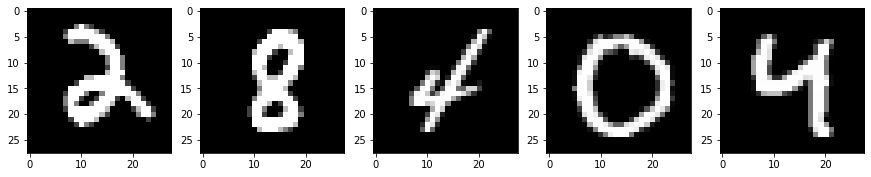

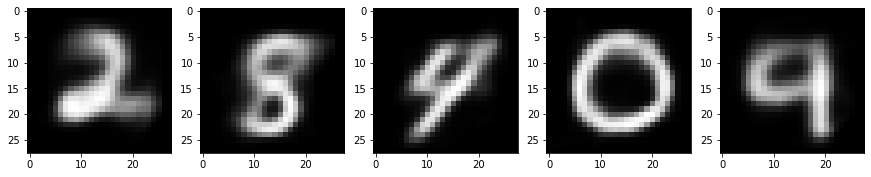

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

for index, (X, _) in enumerate(loader):
        x, z=  net(X.cuda()) if torch.cuda.is_available else net(X)
        break

f,ax = plt.subplots(1,5,figsize=(15, 150))
for i in range(5):
    ax[i].imshow(X[i][0].cpu().detach().reshape((28,28)),cmap='gray')
f,ax = plt.subplots(1,5,figsize=(15, 150))
f.show()
for i in range(5):
    ax[i].imshow(x[i][0].cpu().detach().reshape((28,28)),cmap='gray')

f.show()


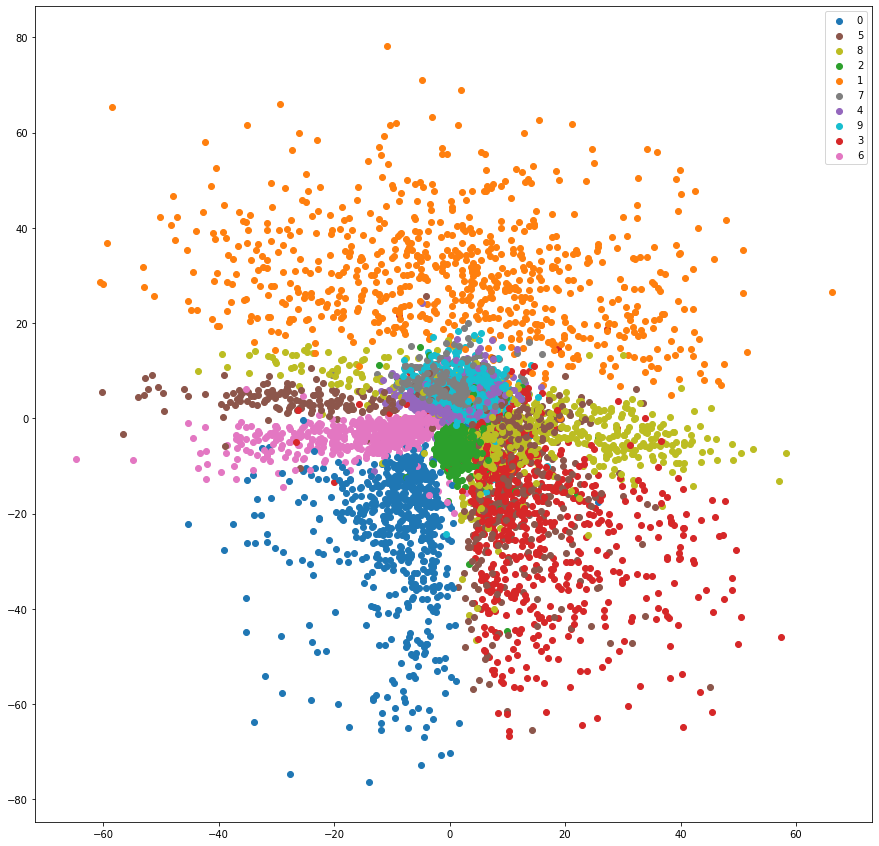

In [0]:
rloss = 0
plt.figure(figsize=(15, 15))
first=np.ones(11)
c = ('tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan')

for index, (X, Y) in enumerate(loader):
        if index==100:
          break
        x, z =  net(X.cuda()) if torch.cuda.is_available else net(X)
        z = z.cpu().detach().numpy() if torch.cuda.is_available else z.detach().numpy() 
        y = Y.cpu().detach().numpy() if torch.cuda.is_available else Y.detach().numpy()
        for i in range(z.shape[0]):
            if first[y[i]]==1:
                     plt.scatter(z[i,0],z[i,1],color=c[y[i]],label=str(y[i]))
                     first[y[i]] = 0
            else:
                     plt.scatter(z[i,0],z[i,1],color=c[y[i]])
plt.legend()
plt.savefig('carte2Dmnist')     
        
 

### Pair classification in the latent space

In [0]:
# we build 200 pairs (100 poisives, 100 negatives)

a = torch.zeros(200,28,28)
b = torch.zeros(200,28,28)
for i in range(200):
    a[i,:,:] = test_set[i][0]
for i in range(200):
    j=i+1
    if i<100: # same
      while test_set[i][1]!=train_set[j][1]:
        j+=1
    else:
      while test_set[i][1]==train_set[j][1]:
        j+=1
    b[i,:,:] = train_set[j][0]

[]

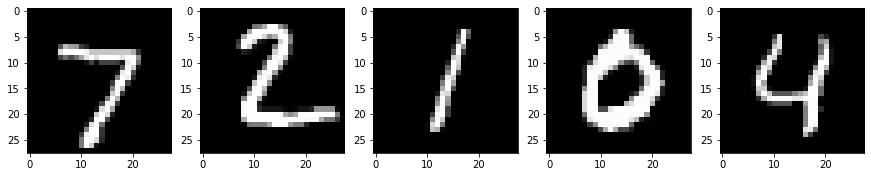

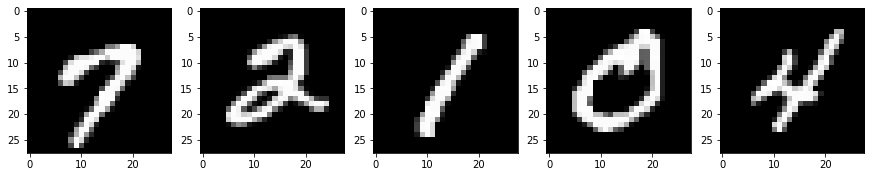

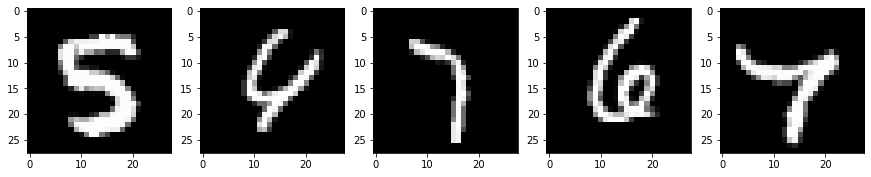

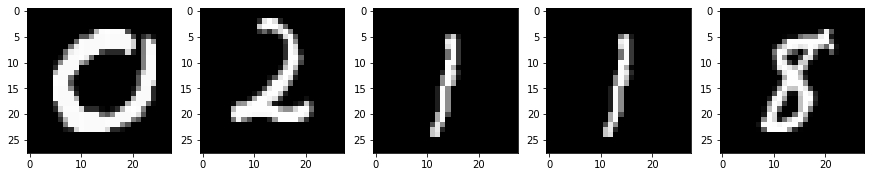

In [0]:
# visualisation of some pairs

f,ax = plt.subplots(1,5,figsize=(15, 150))
for i in range(5):
    ax[i].imshow(a[00+i,:,:].detach().reshape((28,28)),cmap='gray')
plt.plot()
f,ax = plt.subplots(1,5,figsize=(15, 150))
for i in range(5):
    ax[i].imshow(b[00+i,:,:].detach().reshape((28,28)),cmap='gray')
plt.plot()

f,ax = plt.subplots(1,5,figsize=(15, 150))
for i in range(5):
    ax[i].imshow(a[120+i,:,:].detach().reshape((28,28)),cmap='gray')
plt.plot()
f,ax = plt.subplots(1,5,figsize=(15, 150))
for i in range(5):
    ax[i].imshow(b[120+i,:,:].detach().reshape((28,28)),cmap='gray')
plt.plot()

In [0]:
#pait classification

_,aa=net(a.unsqueeze(axis=1).cuda())
_,bb=net(b.unsqueeze(axis=1).cuda())
print(aa.shape,bb.shape)
aa=aa.cpu().detach().numpy()
bb=bb.cpu().detach().numpy()
d=((aa-bb)**2)
d2=((a.reshape(-1,28*28)-b.reshape(-1,28*28))**2).detach().numpy()
print(d.shape)
d=np.sum(d,axis=1)
d2=np.sum(d2,axis=1)
s = np.argsort(d.flatten())<100
s2 = np.argsort(d2.flatten())<100
print('accuracy in the latent space (h=2):',np.sum(s[0:100]),'accuracy in the original space (raw images)=',np.sum(s2[0:100]))

torch.Size([200, 2]) torch.Size([200, 2])
(200, 2)
accuracy in the latent space (h=2): 64 accuracy in the original space (raw images)= 59


In [0]:
print(test_set[2][1])

1
